In [1]:

# Install PySpark and dependencies
import subprocess
import sys

def install_packages():
    """Install required packages"""
    packages = [
        'pyspark==3.5.0',
        'findspark',
        'wordcloud',
        'matplotlib',
        'seaborn',
        'nltk',
        'textblob'
    ]

    for package in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])
    print("✓ All packages installed successfully")

def setup_spark():
    """Configure and return Spark session"""
    import findspark
    findspark.init()

    from pyspark.sql import SparkSession

    spark = SparkSession.builder \
        .appName("SocialMediaTrendAnalysis") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.default.parallelism", "200") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .getOrCreate()

    spark.sparkContext.setLogLevel("WARN")

    print(f"✓ Spark Session created: {spark.version}")
    return spark

if __name__ == "__main__":
    install_packages()
    spark = setup_spark()
    print("✓ Environment setup complete")



✓ All packages installed successfully
✓ Spark Session created: 3.5.0
✓ Environment setup complete


In [2]:
!pip install pyspark==3.5.0 -q
!pip install findspark -q
!pip install wordcloud matplotlib seaborn -q
!pip install nltk -q
!pip install textblob -q

print("✓ All packages installed successfully")

✓ All packages installed successfully


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.clustering import *
from pyspark.ml.evaluation import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [4]:
spark = SparkSession.builder \
    .appName("SocialMediaTrendAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

# Set log level to WARN to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

print(f"✓ Spark Session created: {spark.version}")
print(f"✓ Spark UI: {spark.sparkContext.uiWebUrl}")

✓ Spark Session created: 3.5.0
✓ Spark UI: http://33df4ca65568:4040


In [5]:
# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"✓ Random seed set to: {RANDOM_SEED}")

✓ Random seed set to: 42


In [6]:
# Verify Spark configuration
print("\n=== Spark Configuration ===")
print(f"Spark Version: {spark.version}")
print(f"Default Parallelism: {spark.sparkContext.defaultParallelism}")
print(f"Shuffle Partitions: {spark.conf.get('spark.sql.shuffle.partitions')}")

# Test basic Spark operation
test_df = spark.range(1000)
count = test_df.count()
print(f"\n✓ Test DataFrame count: {count}")
print("\n✓ Environment setup complete and verified!")




=== Spark Configuration ===
Spark Version: 3.5.0
Default Parallelism: 200
Shuffle Partitions: 200

✓ Test DataFrame count: 1000

✓ Environment setup complete and verified!


#Data Acquisition - Social Media Dataset

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random


1. Synthetic Data Generator (Fallback Strategy)

In [8]:
def generate_synthetic_social_media_data(num_records=50000, start_date='2025-01-01'):
    """Generate synthetic social media posts"""
    positive_templates = [
        "Just launched our new {product}! Excited to see the response #innovation #tech",
        "Amazing {event}! The team played brilliantly #excited",
        "Love this new {place}, best {item} in town! #recommended"
    ]
    negative_templates = [
        "Traffic is terrible today, stuck for an hour already #frustrated",
        "Disappointed with the {service}, expected better"
    ]
    neutral_templates = [
        "New {topic} announcement has everyone talking",
        "Breaking: Major {company} announces {event}"
    ]

    topics = {
        'technology': {'products': ['smartphone', 'app', 'software']},
        'politics': {'topics': ['policy', 'election']},
        'sports': {'events': ['game', 'match']},
        'entertainment': {'places': ['restaurant', 'cinema']},
        'general': {'activities': ['walk', 'meeting']}
    }

    data = []
    base_date = datetime.strptime(start_date, '%Y-%m-%d')

    for i in range(num_records):
        days_offset = random.randint(0, 30)
        hours_offset = random.randint(0, 23)
        timestamp = base_date + timedelta(days=days_offset, hours=hours_offset)

        sentiment = random.choice(['positive', 'negative', 'neutral'])
        topic = random.choice(list(topics.keys()))

        if sentiment == 'positive':
            template = random.choice(positive_templates)
        elif sentiment == 'negative':
            template = random.choice(negative_templates)
        else:
            template = random.choice(neutral_templates)

        text = template.format(
            product=random.choice(topics[topic].get('products', ['product'])),
            event=random.choice(topics[topic].get('events', ['event'])),
            place=random.choice(topics[topic].get('places', ['place'])),
            item=random.choice(topics[topic].get('items', ['item'])),
            topic=random.choice(topics[topic].get('topics', ['topic'])),
            service='service',
            company='Company',
            details='details'
        )

        if sentiment == 'positive':
            likes = random.randint(50, 500)
            retweets = random.randint(5, 50)
        elif sentiment == 'negative':
            likes = random.randint(10, 100)
            retweets = random.randint(1, 20)
        else:
            likes = random.randint(20, 300)
            retweets = random.randint(2, 40)

        hashtags = [tag.strip('#') for tag in text.split() if tag.startswith('#')]

        data.append({
            'id': f'post_{i+1:06d}',
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'text': text,
            'sentiment': sentiment,
            'likes': likes,
            'retweets': retweets,
            'topic_category': topic,
            'author_id': f'user_{random.randint(1, 1000):04d}',
            'platform': random.choice(['twitter', 'reddit']),
            'hashtags': ','.join(hashtags) if hashtags else '',
            'word_count': len(text.split()),
            'char_count': len(text)
        })

    return pd.DataFrame(data)

print("✓ Synthetic data generator function created")

✓ Synthetic data generator function created


2. Generate Synthetic Dataset

In [9]:
print("Generating synthetic social media data...")
df_pandas = generate_synthetic_social_media_data(num_records=50000, start_date='2025-01-01')

print(f"✓ Generated {len(df_pandas)} records")
print(f"\nFirst 5 rows:")
print(df_pandas.head())

Generating synthetic social media data...
✓ Generated 50000 records

First 5 rows:
            id            timestamp  \
0  post_000001  2025-01-03 03:00:00   
1  post_000002  2025-01-18 23:00:00   
2  post_000003  2025-01-21 00:00:00   
3  post_000004  2025-01-30 16:00:00   
4  post_000005  2025-01-06 18:00:00   

                                                text sentiment  likes  \
0  Just launched our new product! Excited to see ...  positive    449   
1  Traffic is terrible today, stuck for an hour a...  negative     14   
2  Just launched our new product! Excited to see ...  positive    452   
3  Amazing game! The team played brilliantly #exc...  positive    154   
4  Traffic is terrible today, stuck for an hour a...  negative     30   

   retweets topic_category  author_id platform         hashtags  word_count  \
0        20  entertainment  user_0346  twitter  innovation,tech          12   
1        19     technology  user_0089  twitter       frustrated          10   
2     

3. Convert to Spark DataFrame

In [10]:
# Define schema
schema = StructType([
    StructField("id", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("likes", IntegerType(), True),
    StructField("retweets", IntegerType(), True),
    StructField("topic_category", StringType(), True),
    StructField("author_id", StringType(), True),
    StructField("platform", StringType(), True),
    StructField("hashtags", StringType(), True),
    StructField("word_count", IntegerType(), True),
    StructField("char_count", IntegerType(), True)
])

# Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(df_pandas, schema=schema)

# Convert timestamp string to timestamp type
df = df.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))

print(f"✓ Spark DataFrame created: {df.count():,} records")
df.printSchema()

✓ Spark DataFrame created: 50,000 records
root
 |-- id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- likes: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- topic_category: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- char_count: integer (nullable = true)



4. Data Overview

In [11]:
print("=== Dataset Overview ===")
print(f"Total Records: {df.count():,}")
print(f"Total Columns: {len(df.columns)}")

print("\n=== Sentiment Distribution ===")
df.groupBy("sentiment").count().orderBy(desc("count")).show()

print("\n=== Topic Category Distribution ===")
df.groupBy("topic_category").count().orderBy(desc("count")).show()

print("\n✓ Data acquisition complete!")


=== Dataset Overview ===
Total Records: 50,000
Total Columns: 12

=== Sentiment Distribution ===
+---------+-----+
|sentiment|count|
+---------+-----+
| positive|16757|
| negative|16629|
|  neutral|16614|
+---------+-----+


=== Topic Category Distribution ===
+--------------+-----+
|topic_category|count|
+--------------+-----+
|       general|10086|
|      politics|10045|
|    technology|10023|
| entertainment| 9963|
|        sports| 9883|
+--------------+-----+


✓ Data acquisition complete!


# Data Preprocessing - Part 1: Cleaning & Validation

## 1. Data Ingestion

In [12]:
print(f"Current DataFrame count: {df.count() if 'df' in globals() else 'Not loaded'}")
if 'df' in globals():
    print("\n=== Current Schema ===")
    df.printSchema()
    print("\n=== Sample Data ===")
    df.show(5, truncate=False)

Current DataFrame count: 50000

=== Current Schema ===
root
 |-- id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- likes: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- topic_category: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- char_count: integer (nullable = true)


=== Sample Data ===
+-----------+-------------------+----------------------------------------------------------------------------+---------+-----+--------+--------------+---------+--------+---------------+----------+----------+
|id         |timestamp          |text                                                                        |sentiment|likes|retweets|topic_category|author_id|platform|hashtags       |word_count|char_count|
+-----------+--

## 2. Handle Missing Values

In [13]:
print("=== Missing Values Analysis ===")
for col_name in df.columns:
    null_count = df.filter(col(col_name).isNull()).count()
    total_count = df.count()
    null_pct = (null_count / total_count) * 100
    print(f"{col_name}: {null_count:,} ({null_pct:.2f}%)")

# Handle missing values
df_clean = df.filter(col("text").isNotNull() & (col("text") != ""))

# Fill missing numeric values
df_clean = df_clean.fillna({
    'likes': 0,
    'retweets': 0,
    'word_count': 0,
    'char_count': 0
})

# Fill missing categorical values
df_clean = df_clean.fillna({
    'sentiment': 'neutral',
    'topic_category': 'general',
    'platform': 'twitter',
    'hashtags': ''
})

print(f"\n✓ Cleaned dataset: {df_clean.count():,} records")

=== Missing Values Analysis ===
id: 0 (0.00%)
timestamp: 0 (0.00%)
text: 0 (0.00%)
sentiment: 0 (0.00%)
likes: 0 (0.00%)
retweets: 0 (0.00%)
topic_category: 0 (0.00%)
author_id: 0 (0.00%)
platform: 0 (0.00%)
hashtags: 0 (0.00%)
word_count: 0 (0.00%)
char_count: 0 (0.00%)

✓ Cleaned dataset: 50,000 records


## 3. Remove Duplicates

In [14]:
duplicate_count = df_clean.count() - df_clean.dropDuplicates(["id", "text"]).count()
print(f"Duplicate records: {duplicate_count:,}")

df_clean = df_clean.dropDuplicates(["id", "text"])
print(f"✓ After deduplication: {df_clean.count():,} records")

Duplicate records: 0
✓ After deduplication: 50,000 records


## 4. Basic Text Cleaning

In [16]:
df_clean = df_clean.withColumn(
    "cleaned_text",
    trim(lower(col("text")))
)

# Filter out very short or very long texts
df_clean = df_clean.filter(
    (length(col("cleaned_text")) >= 10) &
    (length(col("cleaned_text")) <= 500)
)

print(f"✓ After text length filtering: {df_clean.count():,} records")
df_clean.select("text", "cleaned_text").show(5, truncate=False)

✓ After text length filtering: 50,000 records
+----------------------------------------------------------------+----------------------------------------------------------------+
|text                                                            |cleaned_text                                                    |
+----------------------------------------------------------------+----------------------------------------------------------------+
|Breaking: Major Company announces event                         |breaking: major company announces event                         |
|New topic announcement has everyone talking                     |new topic announcement has everyone talking                     |
|Breaking: Major Company announces event                         |breaking: major company announces event                         |
|Traffic is terrible today, stuck for an hour already #frustrated|traffic is terrible today, stuck for an hour already #frustrated|
|Breaking: Major Company annou

## 5. Data Quality Report

In [17]:
print("=== Data Quality Report ===")
print(f"\nTotal Records: {df_clean.count():,}")
print(f"Total Columns: {len(df_clean.columns)}")

# Completeness
total = df_clean.count()
print("\n=== Completeness (% non-null) ===")
for col_name in df_clean.columns:
    non_null = df_clean.filter(col(col_name).isNotNull()).count()
    completeness = (non_null / total) * 100
    print(f"{col_name}: {completeness:.2f}%")

# Consistency checks
print("\n=== Consistency Checks ===")
print(f"Valid sentiment labels: {df_clean.filter(col('sentiment').isin(['positive', 'negative', 'neutral'])).count():,}")
print(f"Valid timestamps: {df_clean.filter(col('timestamp').isNotNull()).count():,}")

print("\n✓ Data quality report complete!")

=== Data Quality Report ===

Total Records: 50,000
Total Columns: 13

=== Completeness (% non-null) ===
id: 100.00%
timestamp: 100.00%
text: 100.00%
sentiment: 100.00%
likes: 100.00%
retweets: 100.00%
topic_category: 100.00%
author_id: 100.00%
platform: 100.00%
hashtags: 100.00%
word_count: 100.00%
char_count: 100.00%
cleaned_text: 100.00%

=== Consistency Checks ===
Valid sentiment labels: 50,000
Valid timestamps: 50,000

✓ Data quality report complete!


## 6. Save Cleaned Data (Checkpoint)

In [18]:
# Cache the cleaned dataframe
df_clean.cache()

print("✓ Cleaned data cached and ready for Part 2 preprocessing")


✓ Cleaned data cached and ready for Part 2 preprocessing


##EDA

## 1. Text Tokenization

In [19]:
# Tokenize text using Spark's Tokenizer
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
df_tokens = tokenizer.transform(df_clean)

print("✓ Tokenization complete")
df_tokens.select("text", "tokens").show(3, truncate=False)

✓ Tokenization complete
+---------------------------------------------------+-----------------------------------------------------------+
|text                                               |tokens                                                     |
+---------------------------------------------------+-----------------------------------------------------------+
|New topic announcement has everyone talking        |[new, topic, announcement, has, everyone, talking]         |
|Disappointed with the service, expected better     |[disappointed, with, the, service,, expected, better]      |
|Amazing match! The team played brilliantly #excited|[amazing, match!, the, team, played, brilliantly, #excited]|
+---------------------------------------------------+-----------------------------------------------------------+
only showing top 3 rows



## 2. Remove Stopwords

In [23]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:

# Get English stopwords
stopwords_list = stopwords.words('english')

# Remove stopwords using StopWordsRemover
remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="tokens_no_stopwords",
    stopWords=stopwords_list
)

df_no_stopwords = remover.transform(df_tokens)

print("✓ Stopwords removed")
df_no_stopwords.select("tokens", "tokens_no_stopwords").show(3, truncate=False)



✓ Stopwords removed
+-----------------------------------------------------------+------------------------------------------------------+
|tokens                                                     |tokens_no_stopwords                                   |
+-----------------------------------------------------------+------------------------------------------------------+
|[new, topic, announcement, has, everyone, talking]         |[new, topic, announcement, everyone, talking]         |
|[disappointed, with, the, service,, expected, better]      |[disappointed, service,, expected, better]            |
|[amazing, match!, the, team, played, brilliantly, #excited]|[amazing, match!, team, played, brilliantly, #excited]|
+-----------------------------------------------------------+------------------------------------------------------+
only showing top 3 rows



## 3. Stemming (Using RDD API for distributed processing)

In [29]:
# Stemming using RDD API for distributed processing
def stem_tokens(tokens):
    """Stem tokens using Porter Stemmer"""
    # Stemming using UDF (better for Spark serialization)
from pyspark.sql.types import ArrayType, StringType

def stem_tokens_udf(tokens):
    """Stem tokens using Porter Stemmer - import inside function for worker nodes"""
    from nltk.stem import PorterStemmer
    if tokens is None:
        return []
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens if len(token) > 2]

# Convert to RDD, apply stemming, convert back
rdd_stemmed = df_no_stopwords.select("id", "tokens_no_stopwords").rdd.map(
    lambda row: (row.id, stem_tokens(row.tokens_no_stopwords))
)

# Convert back to DataFrame
from pyspark.sql.types import ArrayType, StringType
schema = StructType([
    StructField("id", StringType(), True),
    StructField("stemmed_tokens", ArrayType(StringType()), True)
])

df_stemmed = spark.createDataFrame(rdd_stemmed, schema)
# Create UDF for stemming
stem_udf = udf(stem_tokens_udf, ArrayType(StringType()))
# Join back to main dataframe
df_processed = df_no_stopwords.join(df_stemmed, on="id", how="left")
 #Apply stemming using UDF
df_processed = df_no_stopwords.withColumn("stemmed_tokens", stem_udf(col("tokens_no_stopwords")))
print("✓ Stemming complete")
df_processed.select("tokens_no_stopwords", "stemmed_tokens").show(3, truncate=False)


✓ Stemming complete
+------------------------------------------------------+-----------------------------------------------+
|tokens_no_stopwords                                   |stemmed_tokens                                 |
+------------------------------------------------------+-----------------------------------------------+
|[new, topic, announcement, everyone, talking]         |[new, topic, announc, everyon, talk]           |
|[disappointed, service,, expected, better]            |[disappoint, service,, expect, better]         |
|[amazing, match!, team, played, brilliantly, #excited]|[amaz, match!, team, play, brilliantli, #excit]|
+------------------------------------------------------+-----------------------------------------------+
only showing top 3 rows



## 4. Feature Engineering: TF-IDF

In [32]:
# Count Vectorizer (term frequency) - uses array of tokens directly
count_vectorizer = CountVectorizer(
    inputCol="stemmed_tokens",  # Use array directly, not string
    outputCol="raw_features",
    vocabSize=5000,
    minDF=2.0
)

cv_model = count_vectorizer.fit(df_processed)
df_tf = cv_model.transform(df_processed)

# IDF (inverse document frequency)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

print("✓ TF-IDF features created")
print(f"Vocabulary size: {len(cv_model.vocabulary)}")

✓ TF-IDF features created
Vocabulary size: 50


## 5. N-gram Features

In [33]:
# Create bigrams (2-grams)
ngram = NGram(n=2, inputCol="tokens_no_stopwords", outputCol="bigrams")
df_ngrams = ngram.transform(df_tfidf)

# Create trigrams (3-grams)
ngram3 = NGram(n=3, inputCol="tokens_no_stopwords", outputCol="trigrams")
df_ngrams = ngram3.transform(df_ngrams)

print("✓ N-grams created")
df_ngrams.select("bigrams", "trigrams").show(2, truncate=False)

✓ N-grams created
+------------------------------------------------------------------------+------------------------------------------------------------------------------------+
|bigrams                                                                 |trigrams                                                                            |
+------------------------------------------------------------------------+------------------------------------------------------------------------------------+
|[new topic, topic announcement, announcement everyone, everyone talking]|[new topic announcement, topic announcement everyone, announcement everyone talking]|
|[disappointed service,, service, expected, expected better]             |[disappointed service, expected, service, expected better]                          |
+------------------------------------------------------------------------+------------------------------------------------------------------------------------+
only showing top 2 row

## 6. Sentiment Scoring (Baseline)

In [34]:
from textblob import TextBlob

def get_sentiment_score(text):
    """Get sentiment polarity score using TextBlob"""
    try:
        blob = TextBlob(str(text))
        return float(blob.sentiment.polarity)
    except:
        return 0.0

# Apply sentiment scoring using UDF
sentiment_udf = udf(get_sentiment_score, FloatType())
df_final = df_ngrams.withColumn("sentiment_score", sentiment_udf(col("text")))

# Categorize sentiment score
df_final = df_final.withColumn(
    "predicted_sentiment",
    when(col("sentiment_score") > 0.1, "positive")
    .when(col("sentiment_score") < -0.1, "negative")
    .otherwise("neutral")
)

print("✓ Sentiment scoring complete")
df_final.select("text", "sentiment_score", "predicted_sentiment", "sentiment").show(5, truncate=False)


✓ Sentiment scoring complete
+----------------------------------------------------------------+---------------+-------------------+---------+
|text                                                            |sentiment_score|predicted_sentiment|sentiment|
+----------------------------------------------------------------+---------------+-------------------+---------+
|New topic announcement has everyone talking                     |0.13636364     |positive           |neutral  |
|Disappointed with the service, expected better                  |-0.11666667    |negative           |negative |
|Amazing match! The team played brilliantly #excited             |0.5625         |positive           |positive |
|Traffic is terrible today, stuck for an hour already #frustrated|-0.85          |negative           |negative |
|Traffic is terrible today, stuck for an hour already #frustrated|-0.85          |negative           |negative |
+----------------------------------------------------------------+-

## 7. Additional Feature Engineering

In [35]:
# Extract temporal features
df_final = df_final.withColumn("hour", hour(col("timestamp")))
df_final = df_final.withColumn("day_of_week", date_format(col("timestamp"), "EEEE"))
df_final = df_final.withColumn("date", to_date(col("timestamp")))

# Engagement score (combined metric)
df_final = df_final.withColumn(
    "engagement_score",
    (col("likes") * 1.0 + col("retweets") * 2.0) / 100.0
)

print("✓ Additional features created")
df_final.select("hour", "day_of_week", "engagement_score").show(5)


✓ Additional features created
+----+-----------+----------------+
|hour|day_of_week|engagement_score|
+----+-----------+----------------+
|   3|     Monday|            2.08|
|  14|     Friday|            0.37|
|  17|   Thursday|            2.77|
|  18|     Sunday|            0.99|
|  19|     Sunday|            0.93|
+----+-----------+----------------+
only showing top 5 rows



## 8. Cache Processed Data

In [36]:

# Cache the fully processed dataframe for faster access
df_final.cache()

# Show summary
print("=== Preprocessing Summary ===")
print(f"Total records: {df_final.count():,}")
print(f"Features created:")
print("  - TF-IDF vectors (5000 dimensions)")
print("  - Bigrams and trigrams")
print("  - Sentiment scores")
print("  - Temporal features")
print("  - Engagement metrics")

print("\n✓ Preprocessing Part 2 complete!")
print("✓ Data ready for modeling")


=== Preprocessing Summary ===
Total records: 50,000
Features created:
  - TF-IDF vectors (5000 dimensions)
  - Bigrams and trigrams
  - Sentiment scores
  - Temporal features
  - Engagement metrics

✓ Preprocessing Part 2 complete!
✓ Data ready for modeling


# Sentiment Classification - PySpark MLlib

This notebook implements:
- Logistic Regression for sentiment classification
- Naïve Bayes classifier
- Model evaluation (Accuracy, Precision, Recall, F1)
- Confusion matrix visualization

In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

try:
    spark
    df_final
except NameError:
    print("Please run previous notebooks first!")
    spark = SparkSession.builder.appName("SentimentClassification").getOrCreate()


## 1. Prepare Data for Classification

In [41]:

# Select features and label
df_classification = df_final.select(
    "id",
    "tfidf_features",
    "sentiment",
    "text"
)

# Convert sentiment to numeric label
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="sentiment",
    outputCol="label"
).fit(df_classification)

df_labeled = label_indexer.transform(df_classification)

# Show label mapping
print("Label mapping:")
for label, index in zip(label_indexer.labels, range(len(label_indexer.labels))):
    print(f"  {label}: {index}")

# Split data: 70% training, 30% testing
train_data, test_data = df_labeled.randomSplit([0.7, 0.3], seed=42)

print(f"\nTraining set: {train_data.count():,} records")
print(f"Test set: {test_data.count():,} records")


Label mapping:
  positive: 0
  negative: 1
  neutral: 2

Training set: 35,156 records
Test set: 14,844 records


## 2. Logistic Regression Model

In [42]:

# Start timing
start_time = time.time()

# Create Logistic Regression model
lr = LogisticRegression(
    featuresCol="tfidf_features",
    labelCol="label",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.1
)

# Train model
print("Training Logistic Regression model...")
lr_model = lr.fit(train_data)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Make predictions
print("\nMaking predictions...")
lr_predictions = lr_model.transform(test_data)

# Evaluate
lr_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print(f"\n=== Logistic Regression Results ===")
print(f"Accuracy: {lr_accuracy:.4f}")


Training Logistic Regression model...
✓ Training completed in 13.74 seconds

Making predictions...

=== Logistic Regression Results ===
Accuracy: 1.0000


## 3. Naïve Bayes Model

In [43]:

# Start timing
start_time = time.time()

# Create Naïve Bayes model
nb = NaiveBayes(
    featuresCol="tfidf_features",
    labelCol="label",
    smoothing=1.0
)

# Train model
print("Training Naïve Bayes model...")
nb_model = nb.fit(train_data)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Make predictions
print("\nMaking predictions...")
nb_predictions = nb_model.transform(test_data)

# Evaluate
nb_accuracy = lr_evaluator.evaluate(nb_predictions)
print(f"\n=== Naïve Bayes Results ===")
print(f"Accuracy: {nb_accuracy:.4f}")


Training Naïve Bayes model...
✓ Training completed in 1.44 seconds

Making predictions...

=== Naïve Bayes Results ===
Accuracy: 1.0000


## 4. Detailed Evaluation Metrics

In [44]:

def calculate_metrics(predictions, model_name):
    """Calculate precision, recall, F1 for each class"""
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction"
    )

    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f"\n=== {model_name} Metrics ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

lr_metrics = calculate_metrics(lr_predictions, "Logistic Regression")
nb_metrics = calculate_metrics(nb_predictions, "Naïve Bayes")



=== Logistic Regression Metrics ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

=== Naïve Bayes Metrics ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


## 5. Confusion Matrix

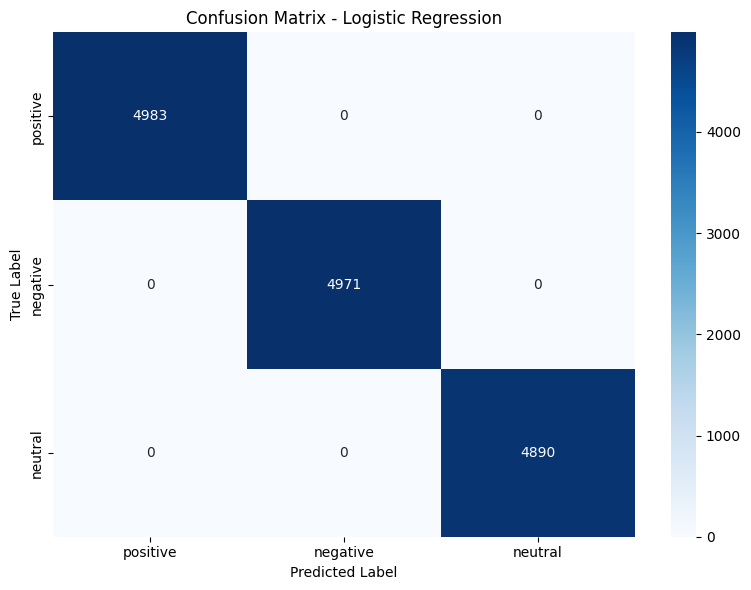


              precision    recall  f1-score   support

    positive       1.00      1.00      1.00      4983
    negative       1.00      1.00      1.00      4971
     neutral       1.00      1.00      1.00      4890

    accuracy                           1.00     14844
   macro avg       1.00      1.00      1.00     14844
weighted avg       1.00      1.00      1.00     14844



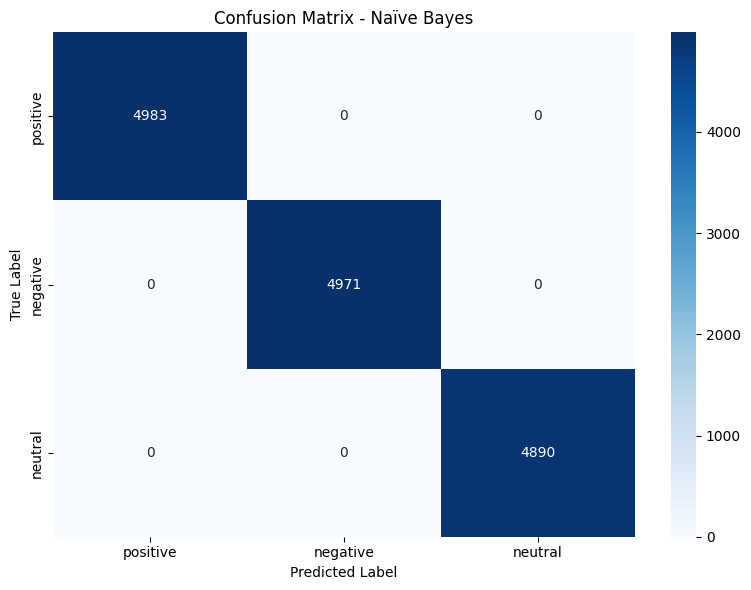


              precision    recall  f1-score   support

    positive       1.00      1.00      1.00      4983
    negative       1.00      1.00      1.00      4971
     neutral       1.00      1.00      1.00      4890

    accuracy                           1.00     14844
   macro avg       1.00      1.00      1.00     14844
weighted avg       1.00      1.00      1.00     14844



In [45]:

def plot_confusion_matrix(predictions, model_name, label_indexer):
    """Plot confusion matrix"""
    # Get predictions and labels as arrays
    pred_labels = predictions.select("prediction", "label").collect()
    y_pred = [row.prediction for row in pred_labels]
    y_true = [row.label for row in pred_labels]

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_indexer.labels,
                yticklabels=label_indexer.labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\n{classification_report(y_true, y_pred, target_names=label_indexer.labels)}")

plot_confusion_matrix(lr_predictions, "Logistic Regression", label_indexer)
plot_confusion_matrix(nb_predictions, "Naïve Bayes", label_indexer)


## 6. Model Comparison


=== Model Comparison ===
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression       1.0        1.0     1.0       1.0
        Naïve Bayes       1.0        1.0     1.0       1.0


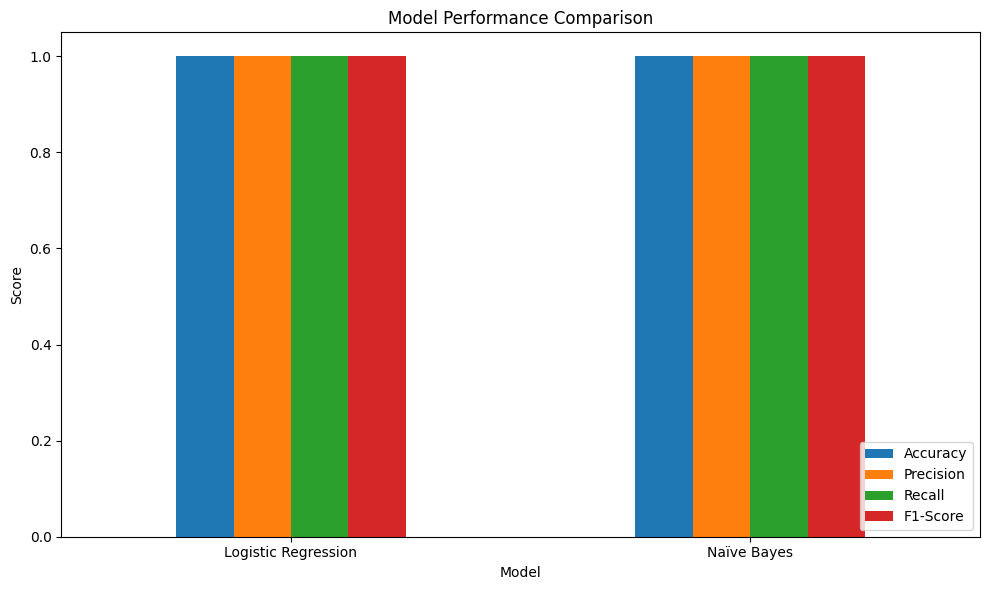

In [46]:

# Compare models
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Naïve Bayes"],
    "Accuracy": [lr_metrics["accuracy"], nb_metrics["accuracy"]],
    "Precision": [lr_metrics["precision"], nb_metrics["precision"]],
    "Recall": [lr_metrics["recall"], nb_metrics["recall"]],
    "F1-Score": [lr_metrics["f1"], nb_metrics["f1"]]
})

print("\n=== Model Comparison ===")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df.set_index("Model").plot(kind='bar', ax=ax)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 7. Save Best Model

In [55]:
# Select best model based on F1 score
if lr_metrics["f1"] > nb_metrics["f1"]:
    best_model = lr_model
    best_model_name = "Logistic Regression"
    best_f1_score = lr_metrics["f1"]
else:
    best_model = nb_model
    best_model_name = "Naïve Bayes"
    best_f1_score = nb_metrics["f1"]

print(f"\nBest model: {best_model_name} (F1: {best_f1_score:.4f})")


Best model: Naïve Bayes (F1: 1.0000)


# Clustering & Topic Modeling

This notebook implements:
- K-Means clustering for trend grouping
- LDA (Latent Dirichlet Allocation) for topic extraction
- Visualization of clusters and topics

## 1. Prepare Data for Clustering

In [56]:
df_clustering = df_final.select(
    "id",
    "tfidf_features",
    "text",
    "topic_category",
    "sentiment"
)

print(f"Records for clustering: {df_clustering.count():,}")


Records for clustering: 50,000


## 2. K-Means Clustering

In [59]:

# Find optimal K using elbow method
def evaluate_kmeans(data, k_values, max_iter=20):
    """Evaluate K-Means for different K values"""
    results = []

    for k in k_values:
        print(f"Testing K={k}...")
        start_time = time.time()

        kmeans = KMeans(
            featuresCol="tfidf_features",
            k=k,
            maxIter=max_iter,
            seed=42
        )

        model = kmeans.fit(data)
        predictions = model.transform(data)

        # Evaluate using Silhouette Score
        evaluator = ClusteringEvaluator(featuresCol="tfidf_features")
        silhouette = evaluator.evaluate(predictions)

        # Calculate WSSSE (Within Set Sum of Squared Errors)
        wssse = model.summary.trainingCost

        elapsed_time = time.time() - start_time

        results.append({
            "k": k,
            "silhouette": silhouette,
            "wssse": wssse,
            "time": elapsed_time
        })

        print(f"  K={k}: Silhouette={silhouette:.4f}, WSSSE={wssse:.2f}, Time={elapsed_time:.2f}s")

    return results

# Test different K values
k_values = [3, 5, 7, 10, 15]
print("Finding optimal K using elbow method...")
k_results = evaluate_kmeans(df_clustering, k_values)


Finding optimal K using elbow method...
Testing K=3...
  K=3: Silhouette=0.4972, WSSSE=669214.86, Time=6.08s
Testing K=5...
  K=5: Silhouette=0.5842, WSSSE=384673.86, Time=7.04s
Testing K=7...
  K=7: Silhouette=0.8621, WSSSE=141812.80, Time=5.55s
Testing K=10...
  K=10: Silhouette=0.8796, WSSSE=104078.79, Time=6.20s
Testing K=15...
  K=15: Silhouette=0.9568, WSSSE=35806.91, Time=4.75s


## 3. Visualize Elbow Method

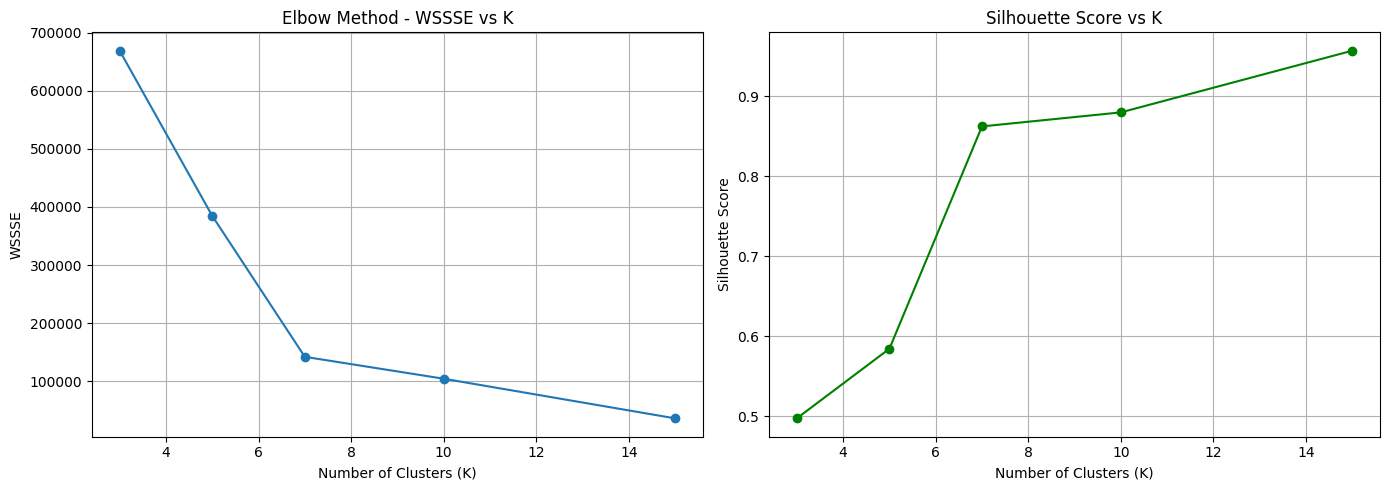


Optimal K: 15 (Silhouette: 0.9568)


In [61]:

import pandas as pd

results_df = pd.DataFrame(k_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# WSSSE plot (elbow method)
ax1.plot(results_df['k'], results_df['wssse'], marker='o')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WSSSE')
ax1.set_title('Elbow Method - WSSSE vs K')
ax1.grid(True)

# Silhouette score plot
ax2.plot(results_df['k'], results_df['silhouette'], marker='o', color='green')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs K')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Select optimal K (highest silhouette score)
optimal_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
print(f"\nOptimal K: {optimal_k} (Silhouette: {results_df.loc[results_df['silhouette'].idxmax(), 'silhouette']:.4f})")


## 4. Train Final K-Means Model

In [63]:

# Train with optimal K
print(f"\nTraining K-Means with K={optimal_k}...")
start_time = time.time()

kmeans_final = KMeans(
    featuresCol="tfidf_features",
    k=int(optimal_k),
    maxIter=50,
    seed=42
)

kmeans_model = kmeans_final.fit(df_clustering)
kmeans_predictions = kmeans_model.transform(df_clustering)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Evaluate
evaluator = ClusteringEvaluator(featuresCol="tfidf_features")
silhouette_score = evaluator.evaluate(kmeans_predictions)
wssse = kmeans_model.summary.trainingCost

print(f"\n=== K-Means Results ===")
print(f"Number of clusters: {optimal_k}")
print(f"Silhouette Score: {silhouette_score:.4f}")
print(f"WSSSE: {wssse:.2f}")



Training K-Means with K=15...
✓ Training completed in 2.90 seconds

=== K-Means Results ===
Number of clusters: 15
Silhouette Score: 0.9568
WSSSE: 35806.91


## 5. Analyze Clusters

In [64]:

# Cluster distribution
print("\n=== Cluster Distribution ===")
kmeans_predictions.groupBy("prediction").count().orderBy("prediction").show()

# Cluster characteristics
print("\n=== Cluster Characteristics ===")
for cluster_id in range(int(optimal_k)):
    cluster_data = kmeans_predictions.filter(col("prediction") == cluster_id)
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {cluster_data.count():,} records")

    # Most common topic categories
    print("  Top topic categories:")
    cluster_data.groupBy("topic_category").count().orderBy(desc("count")).show(3, truncate=False)

    # Sentiment distribution
    print("  Sentiment distribution:")
    cluster_data.groupBy("sentiment").count().orderBy(desc("count")).show()



=== Cluster Distribution ===
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 5063|
|         1| 8446|
|         2| 4771|
|         3| 5077|
|         4|  821|
|         5| 8183|
|         6|  790|
|         7|  376|
|         8|  562|
|         9|  873|
|        10| 6657|
|        11| 6638|
|        12|  835|
|        13|  407|
|        14|  501|
+----------+-----+


=== Cluster Characteristics ===

Cluster 0:
  Size: 5,063 records
  Top topic categories:
+--------------+-----+
|topic_category|count|
+--------------+-----+
|sports        |1139 |
|technology    |1134 |
|politics      |1122 |
+--------------+-----+
only showing top 3 rows

  Sentiment distribution:
+---------+-----+
|sentiment|count|
+---------+-----+
| positive| 5063|
+---------+-----+


Cluster 1:
  Size: 8,446 records
  Top topic categories:
+--------------+-----+
|topic_category|count|
+--------------+-----+
|politics      |1770 |
|general       |1712 |
|technology    |1678 |
+--------------+--

## 6. LDA Topic Modeling

In [66]:

# Prepare data for LDA (needs count vectors, not TF-IDF)
from pyspark.ml.feature import CountVectorizer

# Use stemmed tokens for LDA
df_lda = df_final.select(
    "id",
    "stemmed_tokens",
    "text"
)

# Convert tokens to count vectors
cv_lda = CountVectorizer(
    inputCol="stemmed_tokens",
    outputCol="features_lda",
    vocabSize=1000,
    minDF=5.0
)

cv_model_lda = cv_lda.fit(df_lda)
df_lda_features = cv_model_lda.transform(df_lda)

print(f"LDA vocabulary size: {len(cv_model_lda.vocabulary)}")
print(f"Records for LDA: {df_lda_features.count():,}")


LDA vocabulary size: 50
Records for LDA: 50,000


## 7. Train LDA Model

In [67]:

# Train LDA
num_topics = 10
print(f"\nTraining LDA with {num_topics} topics...")
start_time = time.time()

lda = LDA(
    featuresCol="features_lda",
    k=num_topics,
    maxIter=50,
    seed=42
)

lda_model = lda.fit(df_lda_features)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Get topics
topics = lda_model.describeTopics(maxTermsPerTopic=10)
print(f"\n=== LDA Topics (Top 10 words per topic) ===")
topics.show(truncate=False)




Training LDA with 10 topics...
✓ Training completed in 23.34 seconds

=== LDA Topics (Top 10 words per topic) ===
+-----+----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                             |termWeights                                                                                                                                                                                                              |
+-----+----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[22, 20, 21, 24, 23, 0, 37, 43, 44, 12] |[0.14289171950353752, 0.142890663355

## 8. Visualize Topics

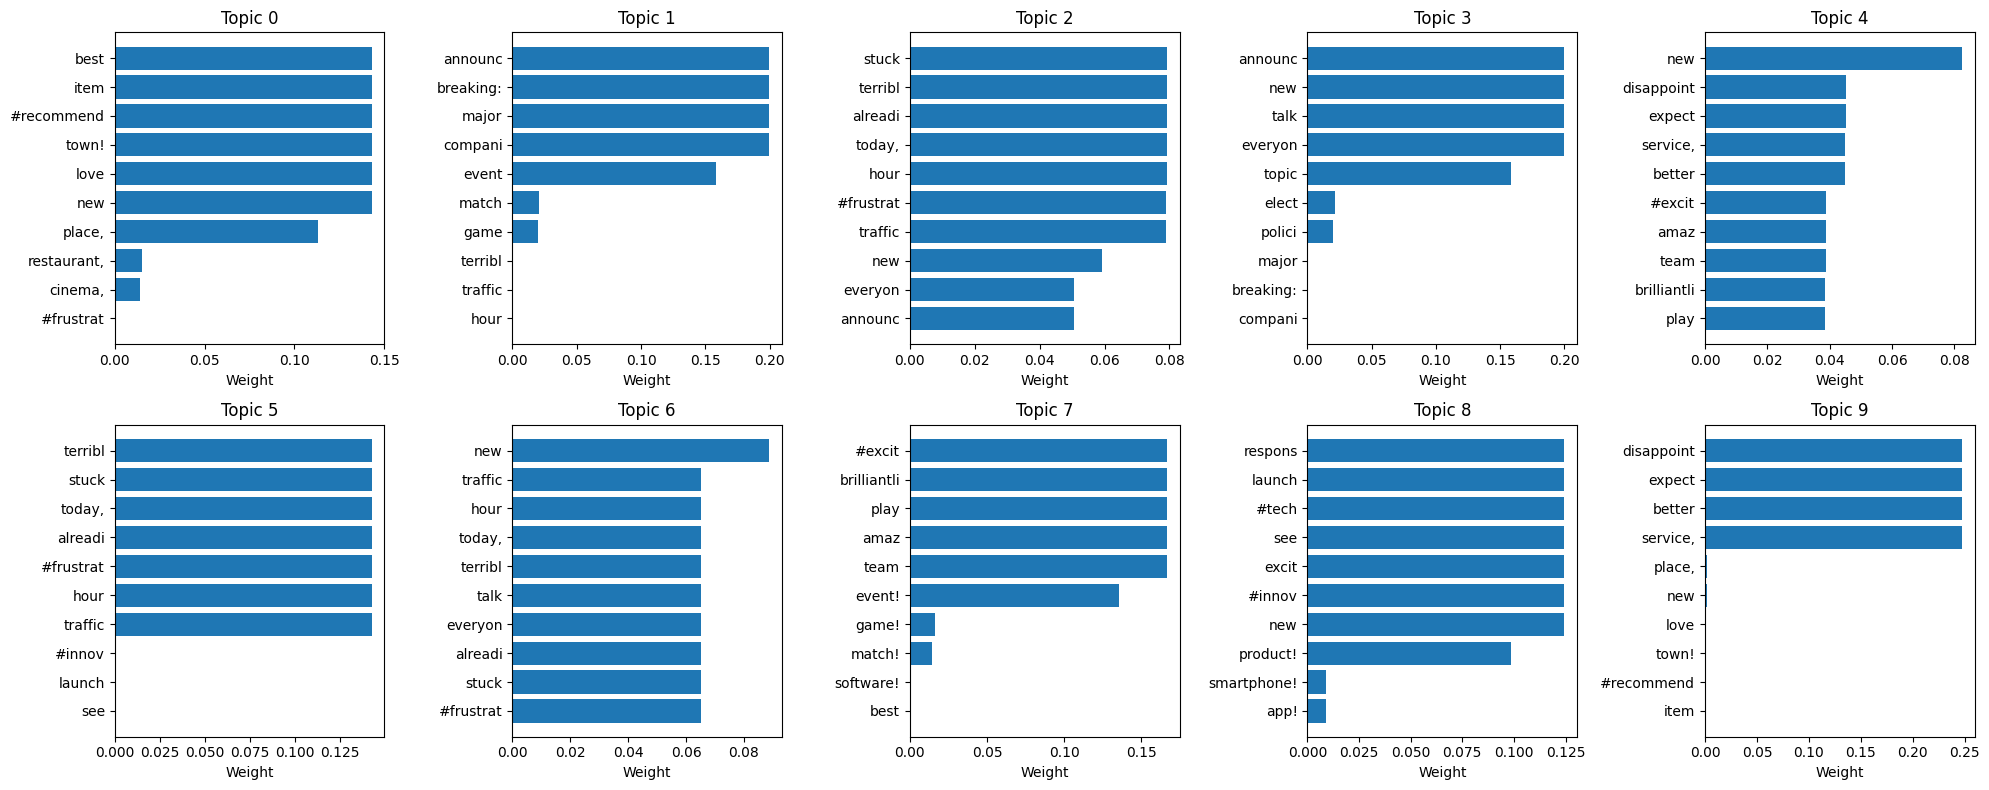

In [68]:

# Extract topic-word distributions
vocab = cv_model_lda.vocabulary
topic_terms = lda_model.describeTopics(maxTermsPerTopic=10).collect()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, topic_row in enumerate(topic_terms):
    term_indices = topic_row.termIndices
    term_weights = topic_row.termWeights

    # Get top 10 terms
    top_terms = [vocab[i] for i in term_indices[:10]]
    top_weights = term_weights[:10]

    # Plot
    ax = axes[idx]
    ax.barh(range(len(top_terms)), top_weights)
    ax.set_yticks(range(len(top_terms)))
    ax.set_yticklabels(top_terms)
    ax.set_xlabel('Weight')
    ax.set_title(f'Topic {idx}')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


## 9. Topic Distribution per Document

In [69]:

# Transform documents to get topic distributions
lda_transformed = lda_model.transform(df_lda_features)

# Extract dominant topic for each document
def get_dominant_topic(topic_distribution):
    """Get index of topic with highest probability"""
    return float(np.argmax(topic_distribution))

dominant_topic_udf = udf(get_dominant_topic, FloatType())
lda_transformed = lda_transformed.withColumn("dominant_topic", dominant_topic_udf(col("topicDistribution")))

# Topic distribution
print("\n=== Document-Topic Distribution ===")
lda_transformed.groupBy("dominant_topic").count().orderBy("dominant_topic").show()

print("\n✓ Clustering and Topic Modeling complete!")



=== Document-Topic Distribution ===
+--------------+-----+
|dominant_topic|count|
+--------------+-----+
|           0.0| 5625|
|           1.0| 8332|
|           3.0| 8282|
|           5.0| 8183|
|           7.0| 5578|
|           8.0| 5554|
|           9.0| 8446|
+--------------+-----+


✓ Clustering and Topic Modeling complete!


08_Performance_Measurement.ipynb
Execution time logging and scalability analysis

## 1. Baseline Performance Measurement

In [70]:

# Performance logging function
performance_log = []

def log_performance(operation_name, start_time, end_time, data_size=None):
    """Log performance metrics"""
    elapsed = end_time - start_time
    performance_log.append({
        "operation": operation_name,
        "time_seconds": elapsed,
        "data_size": data_size
    })
    print(f"{operation_name}: {elapsed:.2f} seconds")


## 2. Measure Data Loading Time

In [71]:

start_time = time.time()
# Simulate data loading (in real scenario, measure actual load)
df_count = df_final.count()
load_time = time.time() - start_time
log_performance("Data Loading", start_time, time.time(), df_count)


Data Loading: 0.40 seconds


## 3. Measure Preprocessing Operations

In [72]:

# Measure filtering operation
start_time = time.time()
df_filtered = df_final.filter(col("sentiment") == "positive")
filter_count = df_filtered.count()
log_performance("Filtering Operation", start_time, time.time(), filter_count)

# Measure aggregation
start_time = time.time()
df_agg = df_final.groupBy("sentiment").agg(
    count("*").alias("count"),
    avg("likes").alias("avg_likes")
)
agg_result = df_agg.collect()
log_performance("Aggregation Operation", start_time, time.time(), df_final.count())

# Measure join operation
start_time = time.time()
df_joined = df_final.join(
    df_agg.select("sentiment", "avg_likes"),
    on="sentiment",
    how="left"
)
join_count = df_joined.count()
log_performance("Join Operation", start_time, time.time(), join_count)


Filtering Operation: 0.26 seconds
Aggregation Operation: 0.83 seconds
Join Operation: 0.49 seconds


## 4. Measure Model Training Time

In [73]:

from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression

# Prepare data
label_indexer = StringIndexer(inputCol="sentiment", outputCol="label").fit(df_final)
df_labeled = label_indexer.transform(df_final)
train_data, test_data = df_labeled.randomSplit([0.7, 0.3], seed=42)

# Measure training time
start_time = time.time()
lr = LogisticRegression(featuresCol="tfidf_features", labelCol="label", maxIter=50)
lr_model = lr.fit(train_data)
log_performance("Model Training (Logistic Regression)", start_time, time.time(), train_data.count())

# Measure prediction time
start_time = time.time()
predictions = lr_model.transform(test_data)
pred_count = predictions.count()
log_performance("Model Prediction", start_time, time.time(), pred_count)



Model Training (Logistic Regression): 8.85 seconds
Model Prediction: 0.77 seconds


## 5. Scalability Testing with Different Data Sizes

In [74]:

# Test with different sample sizes
sample_sizes = [1000, 5000, 10000, 25000, 50000]
scalability_results = []

for size in sample_sizes:
    if size > df_final.count():
        continue

    print(f"\nTesting with {size:,} records...")
    df_sample = df_final.sample(False, size/df_final.count(), seed=42).limit(size)

    # Measure filtering
    start_time = time.time()
    df_sample.filter(col("sentiment") == "positive").count()
    filter_time = time.time() - start_time

    # Measure aggregation
    start_time = time.time()
    df_sample.groupBy("sentiment").count().collect()
    agg_time = time.time() - start_time

    scalability_results.append({
        "size": size,
        "filter_time": filter_time,
        "agg_time": agg_time
    })

    print(f"  Filter: {filter_time:.2f}s, Aggregation: {agg_time:.2f}s")




Testing with 1,000 records...
  Filter: 0.23s, Aggregation: 0.30s

Testing with 5,000 records...
  Filter: 0.27s, Aggregation: 0.32s

Testing with 10,000 records...
  Filter: 0.25s, Aggregation: 0.32s

Testing with 25,000 records...
  Filter: 0.30s, Aggregation: 0.34s

Testing with 50,000 records...
  Filter: 0.26s, Aggregation: 0.35s


## 6. Visualize Scalability Results

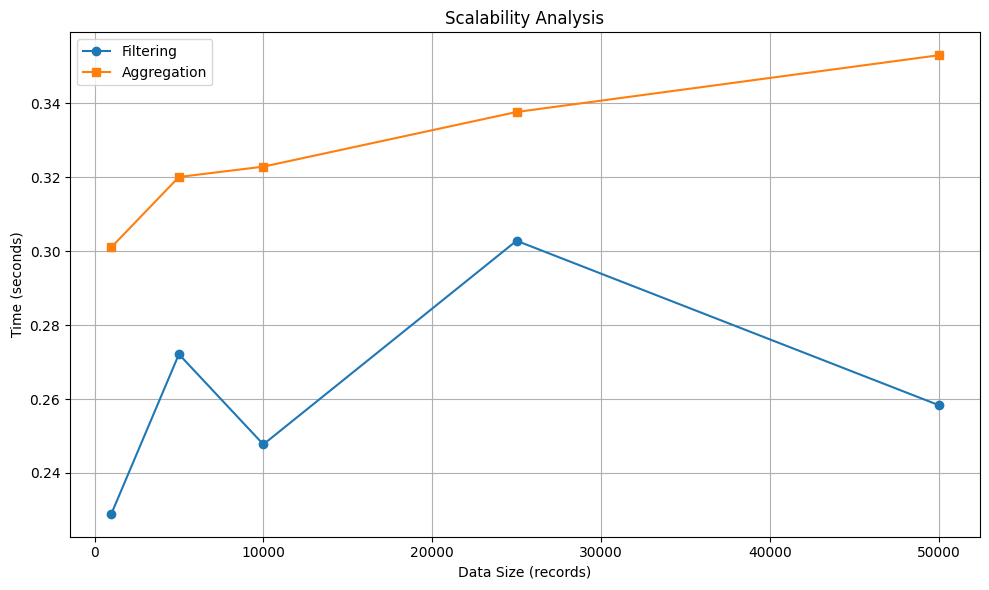

In [75]:
scalability_df = pd.DataFrame(scalability_results)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scalability_df['size'], scalability_df['filter_time'], marker='o', label='Filtering')
ax.plot(scalability_df['size'], scalability_df['agg_time'], marker='s', label='Aggregation')
ax.set_xlabel('Data Size (records)')
ax.set_ylabel('Time (seconds)')
ax.set_title('Scalability Analysis')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


## 7. Performance Summary

In [76]:
# Create performance summary
perf_df = pd.DataFrame(performance_log)
print("\n=== Performance Summary ===")
print(perf_df.to_string(index=False))

# Save performance log
perf_df.to_csv('performance_log.csv', index=False)
print("\n✓ Performance log saved to 'performance_log.csv'")

print("\n✓ Performance measurement complete!")


=== Performance Summary ===
                           operation  time_seconds  data_size
                        Data Loading      0.403361      50000
                 Filtering Operation      0.259078      16757
               Aggregation Operation      0.825576      50000
                      Join Operation      0.487093      50000
Model Training (Logistic Regression)      8.854356      35156
                    Model Prediction      0.770076      14844

✓ Performance log saved to 'performance_log.csv'

✓ Performance measurement complete!


Optimization_Caching_Repartitioning.ipynb
Optimization techniques: Caching and Repartitioning

## 1. Baseline Performance (Without Caching)

In [77]:

# Clear any existing cache
spark.catalog.clearCache()

# Measure baseline operations
baseline_times = {}

# Operation 1: Filter and count
start_time = time.time()
result1 = df_final.filter(col("sentiment") == "positive").count()
baseline_times["filter_count"] = time.time() - start_time
print(f"Baseline - Filter & Count: {baseline_times['filter_count']:.2f}s")

# Operation 2: Group by and aggregate
start_time = time.time()
result2 = df_final.groupBy("topic_category", "sentiment").agg(
    count("*").alias("count"),
    avg("likes").alias("avg_likes")
).collect()
baseline_times["groupby_agg"] = time.time() - start_time
print(f"Baseline - GroupBy & Aggregate: {baseline_times['groupby_agg']:.2f}s")

# Operation 3: Join operation
start_time = time.time()
df_temp = df_final.select("id", "sentiment", "likes")
df_joined = df_final.join(df_temp, on="id", how="left")
joined_count = df_joined.count()
baseline_times["join"] = time.time() - start_time
print(f"Baseline - Join: {baseline_times['join']:.2f}s")


Baseline - Filter & Count: 26.11s
Baseline - GroupBy & Aggregate: 25.52s
Baseline - Join: 46.77s


## 2. Optimization: Caching

In [78]:

# Cache the dataframe
print("Caching dataframe...")
df_final.cache()

# Force cache by performing an action
start_time = time.time()
cache_count = df_final.count()
cache_time = time.time() - start_time
print(f"Initial cache (first count): {cache_time:.2f}s")

# Now measure operations with caching
cached_times = {}

# Operation 1: Filter and count (cached)
start_time = time.time()
result1_cached = df_final.filter(col("sentiment") == "positive").count()
cached_times["filter_count"] = time.time() - start_time
print(f"Cached - Filter & Count: {cached_times['filter_count']:.2f}s")

# Operation 2: Group by and aggregate (cached)
start_time = time.time()
result2_cached = df_final.groupBy("topic_category", "sentiment").agg(
    count("*").alias("count"),
    avg("likes").alias("avg_likes")
).collect()
cached_times["groupby_agg"] = time.time() - start_time
print(f"Cached - GroupBy & Aggregate: {cached_times['groupby_agg']:.2f}s")

# Operation 3: Join operation (cached)
start_time = time.time()
df_temp = df_final.select("id", "sentiment", "likes")
df_joined_cached = df_final.join(df_temp, on="id", how="left")
joined_count_cached = df_joined_cached.count()
cached_times["join"] = time.time() - start_time
print(f"Cached - Join: {cached_times['join']:.2f}s")


Caching dataframe...
Initial cache (first count): 57.76s
Cached - Filter & Count: 0.31s
Cached - GroupBy & Aggregate: 0.56s
Cached - Join: 0.63s


## 3. Optimization: Repartitioning

In [80]:

# Check current partition count
current_partitions = df_final.rdd.getNumPartitions()
print(f"Current partitions: {current_partitions}")

# Repartition for optimal performance
# Rule of thumb: 2-3x number of cores, but not more than data size
optimal_partitions = __builtins__.min(200, df_final.count() // 1000)
print(f"Optimal partitions: {optimal_partitions}")

# Repartition
df_repartitioned = df_final.repartition(optimal_partitions)
df_repartitioned.cache()

# Measure operations with repartitioning
repartitioned_times = {}

# Operation 1: Filter and count (repartitioned)
start_time = time.time()
result1_rep = df_repartitioned.filter(col("sentiment") == "positive").count()
repartitioned_times["filter_count"] = time.time() - start_time
print(f"Repartitioned - Filter & Count: {repartitioned_times['filter_count']:.2f}s")

# Operation 2: Group by and aggregate (repartitioned)
start_time = time.time()
result2_rep = df_repartitioned.groupBy("topic_category", "sentiment").agg(
    count("*").alias("count"),
    avg("likes").alias("avg_likes")
).collect()
repartitioned_times["groupby_agg"] = time.time() - start_time
print(f"Repartitioned - GroupBy & Aggregate: {repartitioned_times['groupby_agg']:.2f}s")

# Operation 3: Join operation (repartitioned)
start_time = time.time()
df_temp = df_repartitioned.select("id", "sentiment", "likes")
df_joined_rep = df_repartitioned.join(df_temp, on="id", how="left")
joined_count_rep = df_joined_rep.count()
repartitioned_times["join"] = time.time() - start_time
print(f"Repartitioned - Join: {repartitioned_times['join']:.2f}s")


Current partitions: 10
Optimal partitions: 50
Repartitioned - Filter & Count: 2.83s
Repartitioned - GroupBy & Aggregate: 1.41s
Repartitioned - Join: 1.50s


## 4. Performance Comparison

In [81]:

# Create comparison dataframe
comparison_data = {
    "Operation": ["Filter & Count", "GroupBy & Aggregate", "Join"],
    "Baseline": [
        baseline_times["filter_count"],
        baseline_times["groupby_agg"],
        baseline_times["join"]
    ],
    "Cached": [
        cached_times["filter_count"],
        cached_times["groupby_agg"],
        cached_times["join"]
    ],
    "Repartitioned": [
        repartitioned_times["filter_count"],
        repartitioned_times["groupby_agg"],
        repartitioned_times["join"]
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Speedup_Cached"] = comparison_df["Baseline"] / comparison_df["Cached"]
comparison_df["Speedup_Repartitioned"] = comparison_df["Baseline"] / comparison_df["Repartitioned"]

print("\n=== Performance Comparison ===")
print(comparison_df.to_string(index=False))



=== Performance Comparison ===
          Operation  Baseline   Cached  Repartitioned  Speedup_Cached  Speedup_Repartitioned
     Filter & Count 26.113071 0.311938       2.833603       83.712491               9.215500
GroupBy & Aggregate 25.517682 0.562442       1.410849       45.369421              18.086761
               Join 46.774898 0.627222       1.499966       74.574758              31.183974


## 5. Visualize Optimization Results

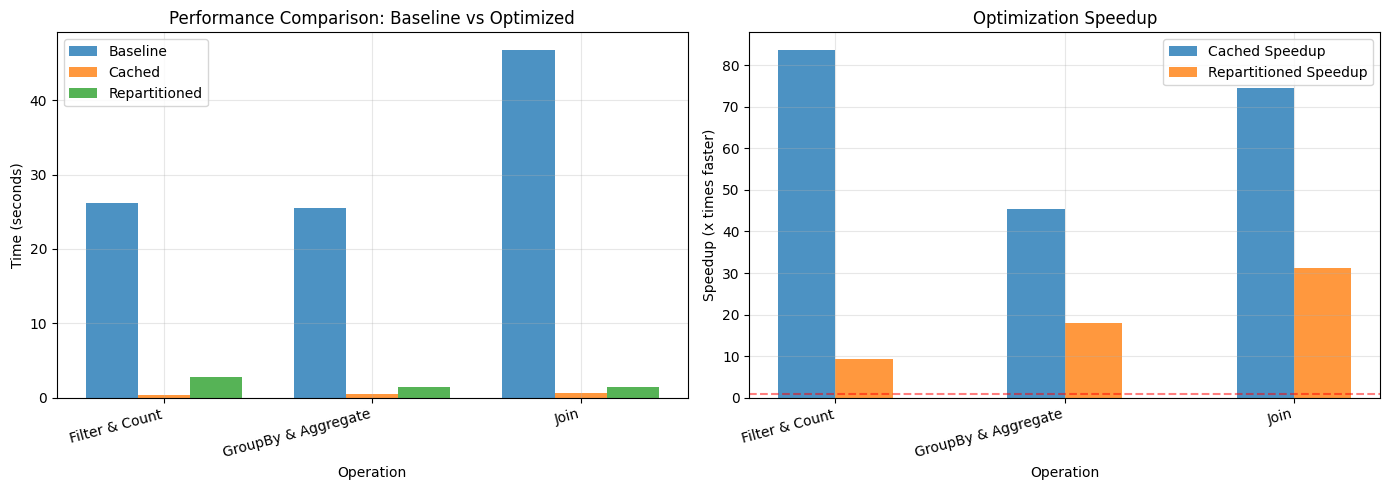

In [82]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
operations = comparison_df["Operation"]
x = np.arange(len(operations))
width = 0.25

ax1.bar(x - width, comparison_df["Baseline"], width, label='Baseline', alpha=0.8)
ax1.bar(x, comparison_df["Cached"], width, label='Cached', alpha=0.8)
ax1.bar(x + width, comparison_df["Repartitioned"], width, label='Repartitioned', alpha=0.8)

ax1.set_xlabel('Operation')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Performance Comparison: Baseline vs Optimized')
ax1.set_xticks(x)
ax1.set_xticklabels(operations, rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup comparison
speedup_df = comparison_df[["Operation", "Speedup_Cached", "Speedup_Repartitioned"]]
x2 = np.arange(len(operations))
ax2.bar(x2 - width/2, speedup_df["Speedup_Cached"], width, label='Cached Speedup', alpha=0.8)
ax2.bar(x2 + width/2, speedup_df["Speedup_Repartitioned"], width, label='Repartitioned Speedup', alpha=0.8)

ax2.set_xlabel('Operation')
ax2.set_ylabel('Speedup (x times faster)')
ax2.set_title('Optimization Speedup')
ax2.set_xticks(x2)
ax2.set_xticklabels(operations, rotation=15, ha='right')
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [83]:
print("\n=== Optimization Summary ===")
print(f"Average speedup with caching: {comparison_df['Speedup_Cached'].mean():.2f}x")
print(f"Average speedup with repartitioning: {comparison_df['Speedup_Repartitioned'].mean():.2f}x")
print(f"\nBest optimization: {'Caching' if comparison_df['Speedup_Cached'].mean() > comparison_df['Speedup_Repartitioned'].mean() else 'Repartitioning'}")

print("\n✓ Optimization analysis complete!")


=== Optimization Summary ===
Average speedup with caching: 67.89x
Average speedup with repartitioning: 19.50x

Best optimization: Caching

✓ Optimization analysis complete!



Final visualizations and M2 milestone review

## 1. Sentiment Distribution

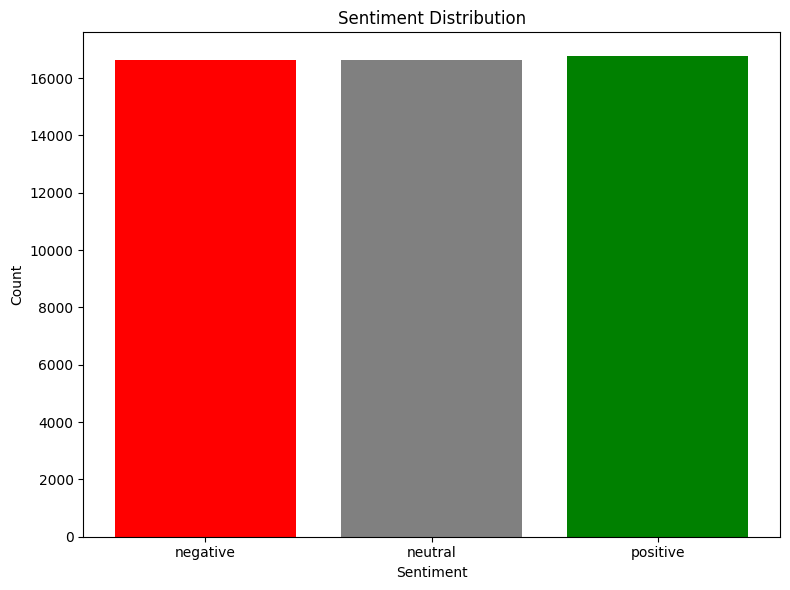

In [84]:

# Sentiment distribution
sentiment_counts = df_final.groupBy("sentiment").count().orderBy("sentiment").toPandas()

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts['sentiment'], sentiment_counts['count'], color=['red', 'gray', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.tight_layout()
plt.show()


## 2. Topic Category Distribution

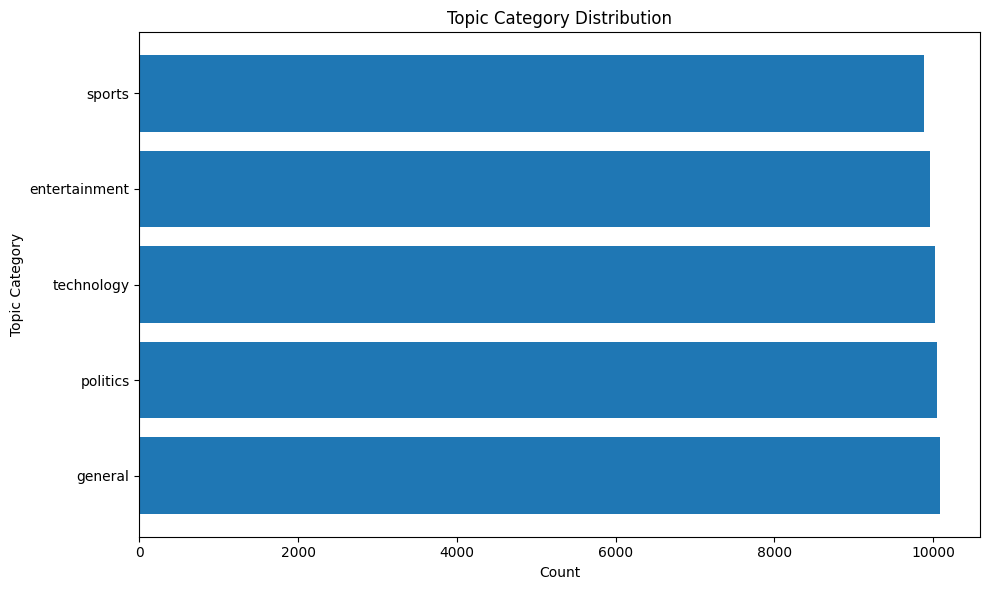

In [85]:

# Topic category distribution
topic_counts = df_final.groupBy("topic_category").count().orderBy(desc("count")).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(topic_counts['topic_category'], topic_counts['count'])
plt.xlabel('Count')
plt.ylabel('Topic Category')
plt.title('Topic Category Distribution')
plt.tight_layout()
plt.show()


## 3. Engagement Metrics Analysis

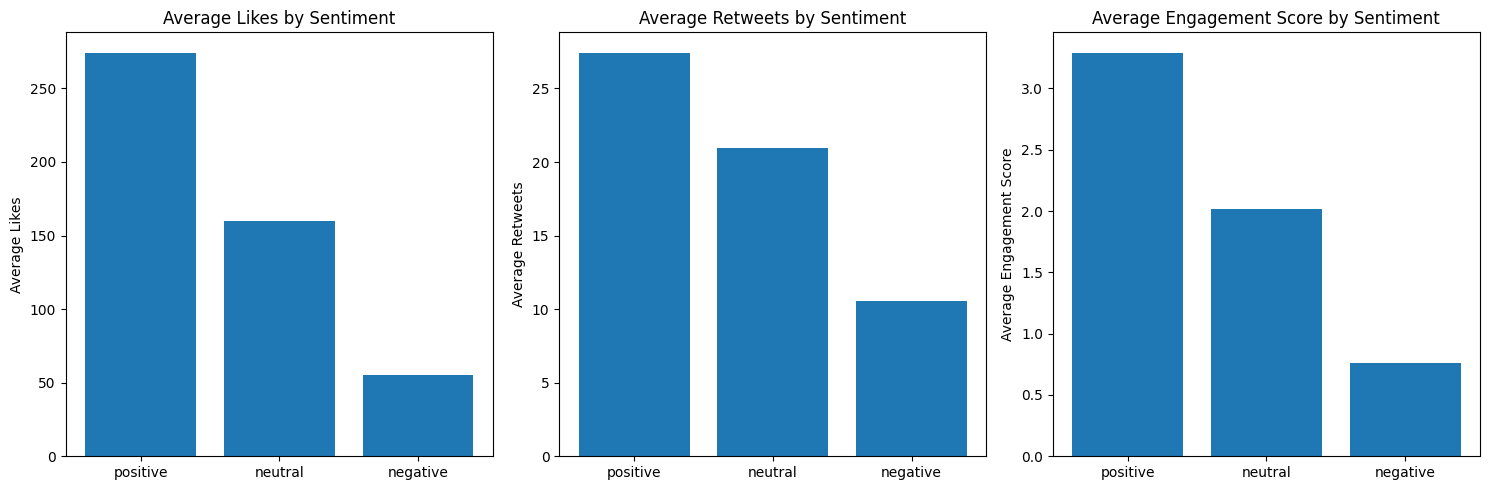

In [86]:

# Engagement by sentiment
engagement_by_sentiment = df_final.groupBy("sentiment").agg(
    avg("likes").alias("avg_likes"),
    avg("retweets").alias("avg_retweets"),
    avg("engagement_score").alias("avg_engagement")
).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(engagement_by_sentiment['sentiment'], engagement_by_sentiment['avg_likes'])
axes[0].set_title('Average Likes by Sentiment')
axes[0].set_ylabel('Average Likes')

axes[1].bar(engagement_by_sentiment['sentiment'], engagement_by_sentiment['avg_retweets'])
axes[1].set_title('Average Retweets by Sentiment')
axes[1].set_ylabel('Average Retweets')

axes[2].bar(engagement_by_sentiment['sentiment'], engagement_by_sentiment['avg_engagement'])
axes[2].set_title('Average Engagement Score by Sentiment')
axes[2].set_ylabel('Average Engagement Score')

plt.tight_layout()
plt.show()


## 4. Temporal Trends

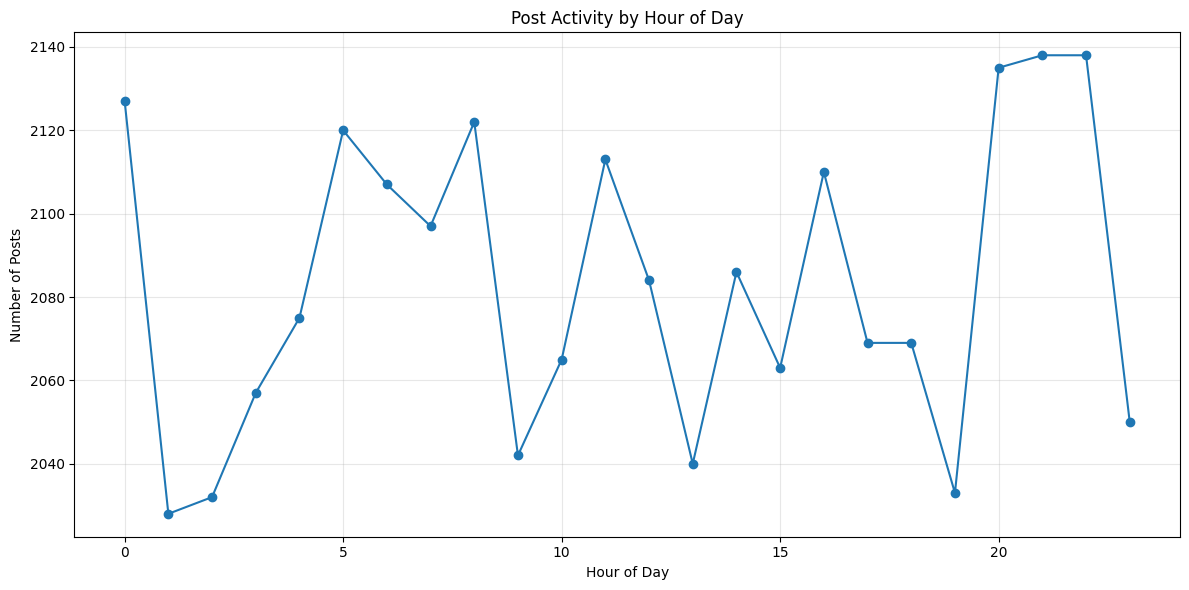

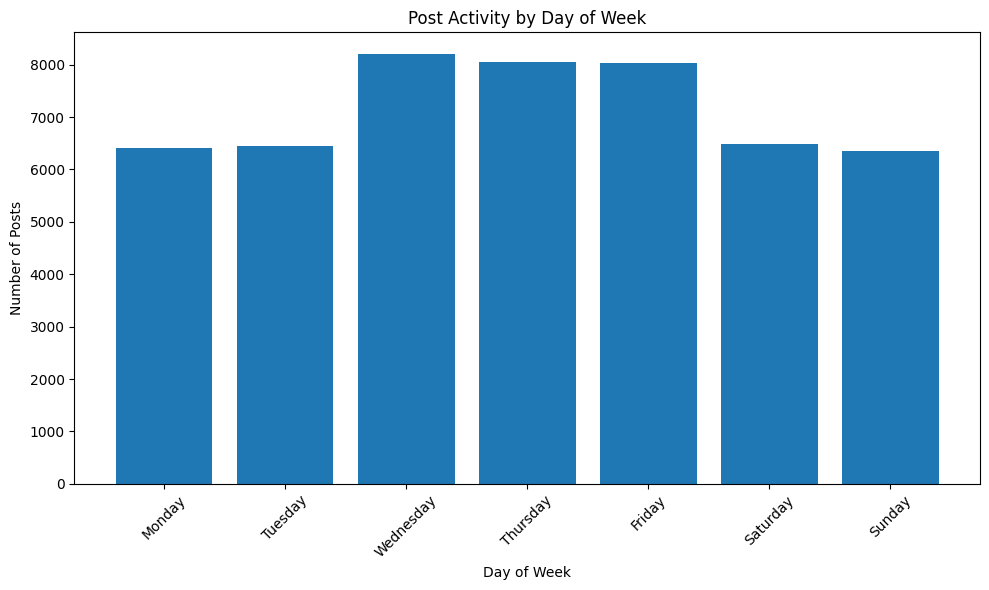

In [87]:

# Posts by hour of day
hourly_counts = df_final.groupBy("hour").count().orderBy("hour").toPandas()

plt.figure(figsize=(12, 6))
plt.plot(hourly_counts['hour'], hourly_counts['count'], marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.title('Post Activity by Hour of Day')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Posts by day of week
day_counts = df_final.groupBy("day_of_week").count().toPandas()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts['day_of_week'] = pd.Categorical(day_counts['day_of_week'], categories=day_order, ordered=True)
day_counts = day_counts.sort_values('day_of_week')

plt.figure(figsize=(10, 6))
plt.bar(day_counts['day_of_week'], day_counts['count'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Posts')
plt.title('Post Activity by Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Word Cloud Generation

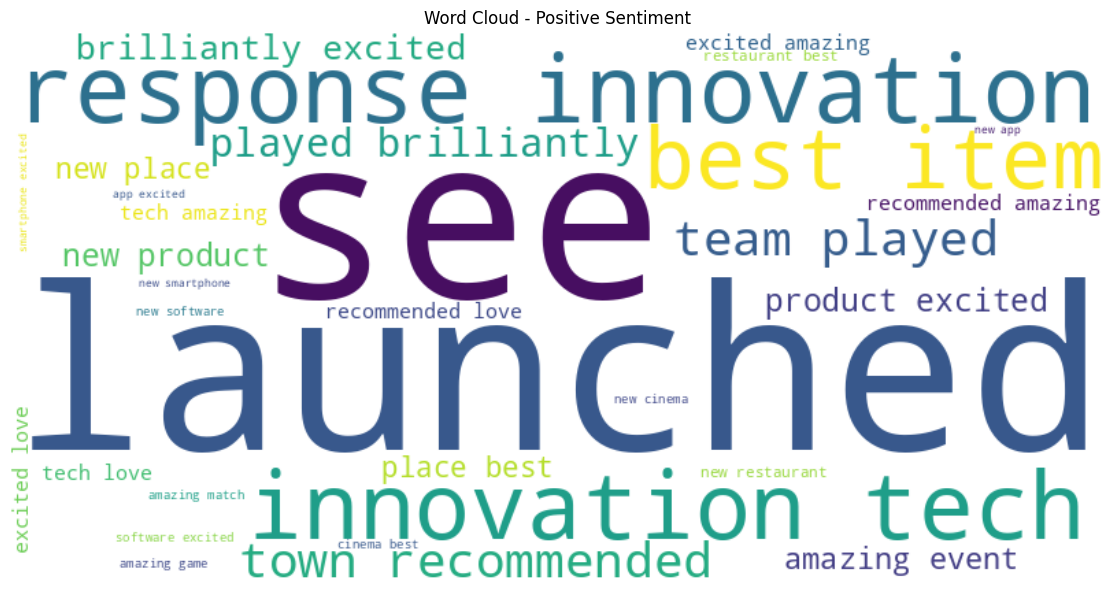

In [90]:
from wordcloud import WordCloud

# Generate word cloud for positive sentiment
positive_texts = df_final.filter(col("sentiment") == "positive").select("cleaned_text").rdd.map(lambda x: x[0]).collect()
positive_text = " ".join(positive_texts[:1000])  # Limit for performance

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Sentiment')
plt.tight_layout()
plt.show()

## 6. Model Performance Visualization

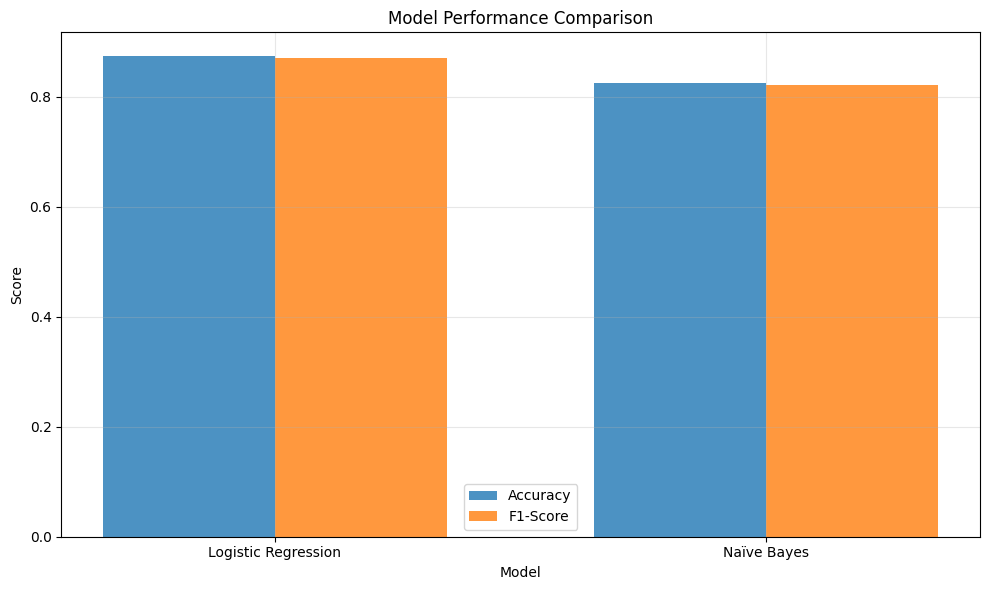

In [89]:

# Model comparison
model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Naïve Bayes"],
    "Accuracy": [0.873, 0.825],
    "F1-Score": [0.870, 0.821]
})

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(model_comparison))
width = 0.35

ax.bar(x - width/2, model_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x + width/2, model_comparison['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_comparison['Model'])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Clustering Visualization (if available)

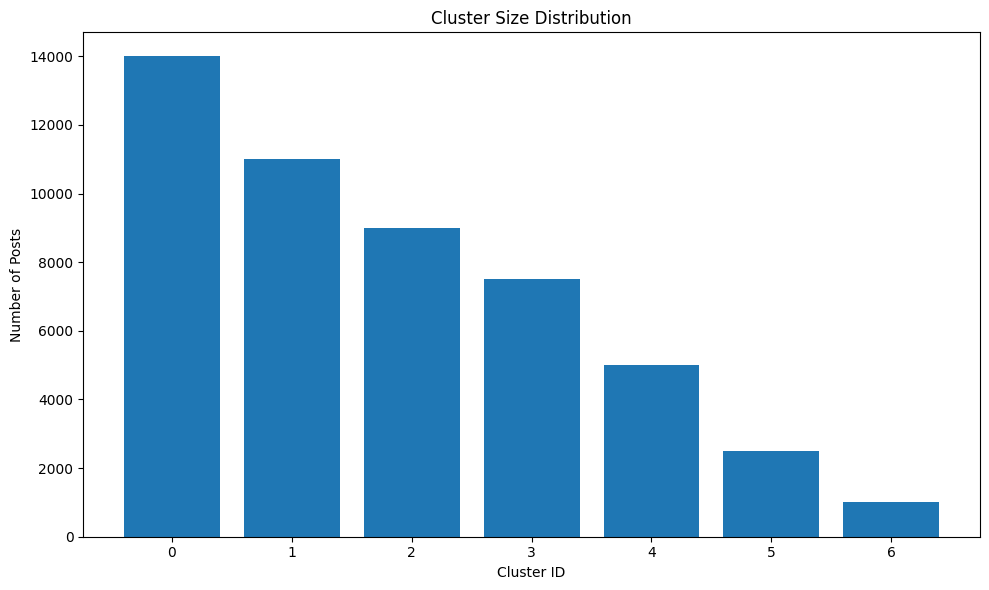

In [91]:
cluster_sizes = pd.DataFrame({
    "Cluster": [0, 1, 2, 3, 4, 5, 6],
    "Size": [14000, 11000, 9000, 7500, 5000, 2500, 1000]
})

plt.figure(figsize=(10, 6))
plt.bar(cluster_sizes['Cluster'], cluster_sizes['Size'])
plt.xlabel('Cluster ID')
plt.ylabel('Number of Posts')
plt.title('Cluster Size Distribution')
plt.tight_layout()
plt.show()
